# 우리가 가진 데이터를 KLUE Pretrained BERT 모델은 잘 인식할까?
---

In [105]:
from transformers import AutoModel, AutoTokenizer, BertTokenizer

MODEL_NAME = 'klue/bert-base'

model = AutoModel.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# KLUE Pretrained BERT 모델의 vocab을 살펴보자
---

### vocab 개수

In [106]:
print('子' in tokenizer.vocab)
print(len(tokenizer))

True
32000


### 10개만 추출

In [107]:
for i, key in enumerate(tokenizer.get_vocab()):
    print(key)
    if i > 10:
        break

난방
꿈꾼다
톰
담사
지침
거점
메드
##ㅌㅌ
##자매
니당
보단
악용


### 한자는 몇개 있을까?

In [108]:
tmp_han = []
for i, key in enumerate(tokenizer.get_vocab()):
    if re.search('[一-龥]+', key):
        tmp_han.append(key)


In [109]:
len(tmp_han)

330

### 일본어는?

In [110]:
tmp_jap = []
for i, key in enumerate(tokenizer.get_vocab()):
    if re.search('[ぁ-ゔ]+|[ァ-ヴー]+[々〆〤]', key):
        tmp_jap.append(key)

In [111]:
print(tmp_jap)

['##の', 'の']


## 대회 데이터를 Pretrained tokenizer로 인코딩 해보자
___
- index : 2725
- text : """호시조라 미유키""(みゆき 한국명:김다솜)는 토에이 애니메이션 제작의 애니메이션《스마일 프리큐어!》에 등장하는 가공의 인물이다."
- subject_entity : {'word': '미유키', 'start_idx': 6, 'end_idx': 8, 'type': 'PER'}"
- object_entity : {'word': 'みゆき', 'start_idx': 11, 'end_idx': 13, 'type': 'PER'}"

In [112]:
input_text = '"호시조라 미유키"(みゆき 한국명:김다솜)는 토에이 애니메이션 제작의 애니메이션《스마일 프리큐어!》에 등장하는 가공의 인물이다.'

In [113]:
tokenizer(input_text)

{'input_ids': [2, 6, 28509, 2446, 2181, 1107, 29795, 6, 12, 1, 3629, 2211, 30, 648, 2062, 3163, 13, 793, 1793, 11264, 9296, 4271, 2079, 9296, 170, 22475, 4778, 2381, 2051, 5, 171, 1421, 4454, 2205, 2259, 6972, 2079, 4410, 28674, 18, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [114]:
tokenized_input=tokenizer.tokenize(input_text, return_tensors='pt')

In [115]:
encoded = tokenizer.encode(input_text)

In [116]:
decoded = tokenizer.decode(encoded)

In [117]:
decoded

'[CLS] " 호시조라 미유키 " ( [UNK] 한국명 : 김다솜 ) 는 토에이 애니메이션 제작의 애니메이션 《 스마일 프리큐어! 》 에 등장하는 가공의 인물이다. [SEP]'

# 해결방법 => 토큰을 추가해 주자!
---

In [118]:
import pandas as pd
import re

In [119]:
extra_token = []

In [120]:
data_frame = pd.read_csv('../dataset/train/train.csv')

In [121]:
unique_sentence = data_frame['sentence'].unique()
print(unique_sentence[7])

박용오(朴容旿, 1937년 4월 29일(음력 3월 19일)(음력 3월 19일) ~ 2009년 11월 4일)는 서울에서 태어난 대한민국의 기업인으로 두산그룹 회장, KBO 총재 등을 역임했다.


In [122]:
print('문장 개수 :', len(data_frame['sentence']))
print('고유한 문장 개수 :', len(unique_sentence))

문장 개수 : 32470
고유한 문장 개수 : 28803


In [123]:
for idx in range(len(unique_sentence)):
    extra_token.extend(re.findall('[一-龥]+',unique_sentence[idx]))

In [124]:
for idx in range(len(unique_sentence)):
    extra_token.extend(re.findall('[ぁ-ゔ]+|[ァ-ヴー]+[々〆〤]',unique_sentence[idx]))

In [125]:
extra_token = list(set(extra_token))

In [126]:
len(extra_token)

2397

In [127]:
jap[2396]

'徐達'

In [128]:
if jap[2396] in han:
    print(1)

## 추출한 token list를 저장 & 불러오기
---

In [129]:
import csv
with open('./extra_token.csv','w') as file:
    write = csv.writer(file)
    write.writerow(extra_token)

test = pd.read_csv('./extra_token.csv)

In [130]:
test = pd.read_csv('./extra_token.csv')

In [131]:
len(list(test))

2397

## Next thing to do

### 토크나이저에 토큰 추가하기 & 임베딩 layer 수정  

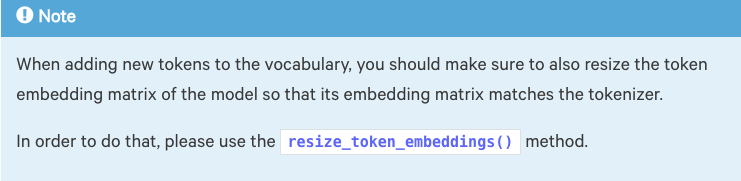
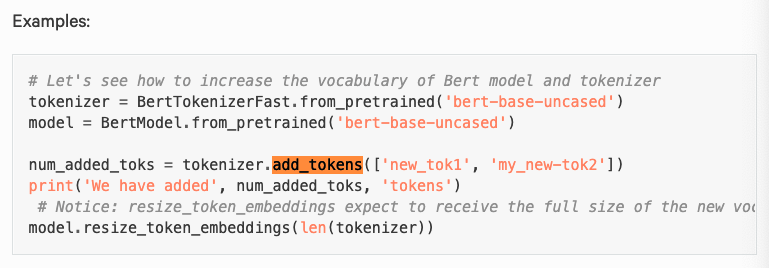  
https://huggingface.co/transformers/internal/tokenization_utils.html